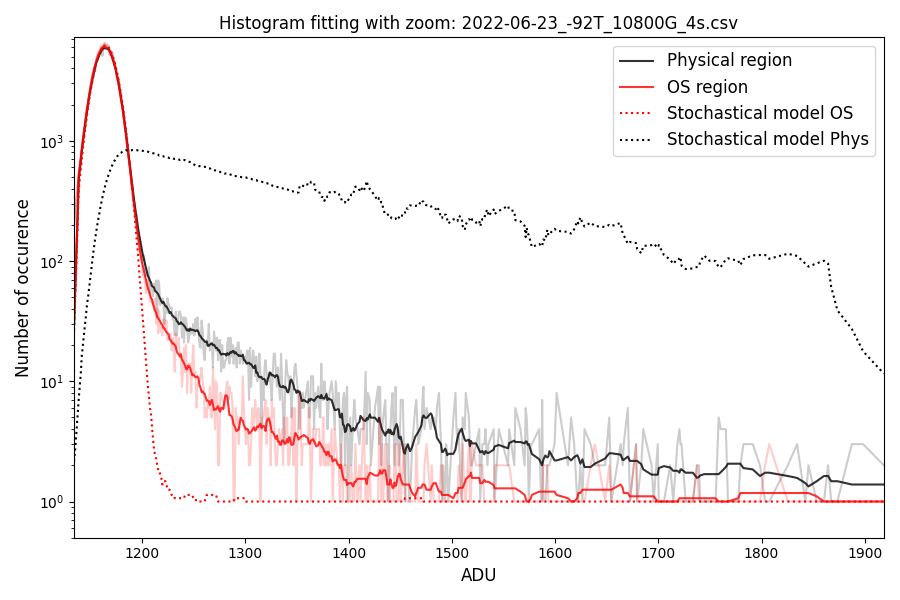

In [8]:
%matplotlib widget
%reload_ext autoreload
from ipywidgets import interact, interactive, fixed, interact_manual,Layout , VBox, HBox
import ipywidgets as widgets
import numpy as np
from scipy.sparse import dia_matrix
from astropy.table import Table
import glob
import os
import matplotlib.pyplot as plt



n_conv = 11


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

 
def PlotFit1D(
    x=None,
    y=[709, 1206, 1330],
    deg=1,
    plot_=True,
    sigma_clip=None,
    title=None,
    xlabel=None,
    ylabel=None,
    P0=None,
    bounds=(-1e10, 1e10),
    fmt=".",
    ax=None,
    # c="black",
    Type="normal",
    sigma=None,
    # ls=":",
    interactive=False,
    **kwargs,
):
    """ PlotFit1D(np.arange(100),np.arange(100)**2
    + 1000*np.random.poisson(1,size=100),2)
    """
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from decimal import Decimal
    import numpy as np

    x, y = np.array(x), np.array(y)

    if x is None:
        x = np.arange(len(y))

    if sigma is not None:
        x = x[np.isfinite(y)]
        y = y[np.isfinite(y)]
        sigma = sigma[np.isfinite(y)]
    else:
        x = x[np.isfinite(y)]
        y = y[np.isfinite(y)]

    x = np.array(x)
    y = np.array(y)

    if sigma_clip is not None:
        index = (
            (x > np.nanmean(x) - sigma_clip[0] * np.nanstd(x))
            & (x < np.nanmean(x) + sigma_clip[0] * np.nanstd(x))
            & (y > np.nanmean(y) - sigma_clip[1] * np.nanstd(y))
            & (y < np.nanmean(y) + sigma_clip[1] * np.nanstd(y))
        )
        x, y = x[index], y[index]
        std = np.nanstd(y)
    else:

        sigma_clip = [10, 1]
        index = (
            (x > np.nanmean(x) - sigma_clip[0] * np.nanstd(x))
            & (x < np.nanmean(x) + sigma_clip[0] * np.nanstd(x))
            & (y > np.nanmean(y) - sigma_clip[1] * np.nanstd(y))
            & (y < np.nanmean(y) + sigma_clip[1] * np.nanstd(y))
        )
        std = np.nanstd(y[index])

    if plot_ & (ax is None):
        fig = plt.figure()  # figsize=(10,6))
        gs = gridspec.GridSpec(2, 1, height_ratios=(4, 1))
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        if sigma is None:
            ax1.plot(x, y, fmt, label="Data", **kwargs)
        else:
            ax1.errorbar(x, y, fmt=fmt, yerr=sigma, **kwargs)

    xp = np.linspace(x.min(), x.max(), 1000)

    def linear_func(p, x):
        m, c = p
        return m * x + c

    if type(deg) == int:
        z, res, rank, singular, rcond = np.polyfit(x, y, deg, full=True)
        pcov = None
        popt = np.poly1d(z)
        law = np.poly1d(z)
        if (deg == 1) & (Type == "ortho"):
            import scipy

            linear_model = scipy.odr.Model(linear_func)
            data = scipy.odr.RealData(x, y)
            odr = scipy.odr.ODR(data, linear_model, beta0=[0.0, 1.0])
            out = odr.run()
            popt = np.poly1d(out.beta)
            law = np.poly1d(out.beta)
        zp = popt(xp)
        if P0 is not None:
            z0 = np.poly1d(P0)(xp)
        zz = popt(x)
        degs = [" %0.2f * x^%i" % (a, i) for i, a in enumerate(popt.coef[::-1])]
        # name = "Fit: " + "+".join(degs) + ", R=%0.2E" % (Decimal(res[0]))
    else:
        from scipy.optimize import curve_fit

        if deg == "exp":

            def law(x, b, a, offset):
                return b * np.exp(-x / a) + offset

            if P0 is None:
                P0 = [np.nanmax(y) - np.nanmin(y), 1, np.nanmin(y)]
        if deg == "2exp":
            law = (
                lambda x, b1, b2, a1, a2, offset: b1 * np.exp(-x / a1)
                + b2 * np.exp(-x / a2)
                + offset
            )
        elif deg == "gaus":
            law = (
                lambda x, a, xo, sigma, offset: a ** 2
                * np.exp(-np.square((x - xo) / sigma) / 2)
                + offset
            )
            if P0 is None:
                P0 = [
                    np.nanmax(y) - np.nanmin(y),
                    x[np.argmax(y)],
                    np.std(y),
                    np.nanmin(y),
                ]
        elif deg == "power":

            def law(x, amp, index, offset):
                return amp * (x ** index) + offset

            P0 = None
        elif callable(deg):
            law = deg
        if P0 is not None:
            z0 = law(xp, *P0)

        if interactive:
            print("Interactive Fit")
            from IPython import get_ipython

            get_ipython().run_line_magic("matplotlib", "")
            if len(P0) == 1:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 2:
                print("Interactive Fit")
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 3:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f,c*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 4:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f,c*%f,d*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            plt.show()
            get_ipython().run_line_magic("matplotlib", "inline")
            return {
                "popt": np.zeros(len(P0)),
                "pcov": np.zeros((len(P0), len(P0))),
                "res": 0,
                "y": y,
                "x": x,
                "curve": [],
            }
        try:
            popt, pcov = curve_fit(law, x, y, p0=P0, bounds=bounds, sigma=sigma)
        except RuntimeError as e:
            # print(law)
            # print(type(law))
            # print(e)
            if interactive:
                if input("Do you want to fit it manually? [y/n]") == "y":
                    from IPython import get_ipython

                    get_ipython().run_line_magic("matplotlib", "")
                    if len(P0) == 1:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 2:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 3:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f,c*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 4:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f,c*%f,d*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    get_ipython().run_line_magic("matplotlib", "inline")
                    return {
                        "popt": np.zeros(len(P0)),
                        "pcov": np.zeros((len(P0), len(P0))),
                        "res": 0,
                        "y": y,
                        "x": x,
                        "curve": [],
                    }
            else:
                return {
                    "popt": np.zeros(len(P0)),
                    "pcov": np.zeros((len(P0), len(P0))),
                    "res": 0,
                    "y": y,
                    "x": x,
                    "curve": [],
                }
        res = -99
        res = np.sum(np.square(y - law(x, *popt)))
        zp = law(xp, *popt)
        zz = law(x, *popt)
        name = "Fit %s, R=%0.2E" % (
            np.round(np.array(popt, dtype=int), 0),
            Decimal(res),
        )
    if plot_:
        if ax is None:
            # if deg == "gaus":
            # ax1.text(
            #     popt[1], popt[0] ** 2, "Max = %0.1f std" % (popt[0] ** 2 / std),
            # )
            if title:
                fig.suptitle(title, y=1)
            if xlabel:
                ax2.set_xlabel(xlabel)
            if ylabel:
                ax1.set_ylabel(ylabel)
            ax1.tick_params(
                axis="x", which="both", bottom=False, top=False, labelbottom=False,
            )
            ax2.set_ylabel("Error")
            line = ax1.plot(xp, zp, **kwargs)
            # if P0 is not None:
            #     ax1.plot(xp, z0, ":")
            ax2.plot(x, y - zz, fmt, **kwargs)
            ax2.set_xlim(ax1.get_xlim())
            ax2.plot([-1e100, 1e100], [0, 0], **kwargs)
            ax1.grid(linestyle="dotted")
            ax2.grid(linestyle="dotted")
            ax1.legend()
            plt.tight_layout()
        else:
            xp = np.linspace(
                np.nanmin(xp) - 2 * xp.ptp(), np.nanmax(xp) + 2 * xp.ptp(), 5 * len(xp),
            )
            try:
                line = ax.plot(xp, np.poly1d(z)(xp), **kwargs)
            except UnboundLocalError:
                line = ax.plot(xp, law(xp, *popt), **kwargs)
            ax1, ax2 = ax, ax
        return {
            "popt": popt,
            "pcov": pcov,
            "res": res,
            "axes": [ax1, ax2],
            "y": y,
            "x": x,
            "curve": line,
            "sigma": sigma,
            "y_fit": zz,
            "function": law,
        }
    else:
        return {
            "popt": popt,
            "pcov": pcov,
            "res": res,
            "y": y,
            "x": x,
            "curve": [],
            "sigma": sigma,
            "y_fit": zz,
            "function": law,
        }
    return {
        "popt": popt,
        "pcov": pcov,
        "res": res,
        "y": y,
        "x": x,
        "curve": [],
        "sigma": sigma,
        "y_fit": zz,
        "function": law,
    }




def init_values(bins,val,val_os,plot_=False):
    bins_os=bins
    os_v = val_os
    bias = bins_os[np.nanargmax(val_os)] + 0.5  #  #ADDED xdata[np.nanargmax(ydata)]
    if bias > 1500:
        conversion_gain = 0.53  
        smearing = 1.5 
        gain_factor=2
        RN = 60 
    else:
        conversion_gain = 1 / 4.5 
        smearing = 0.7  
        RN = 10
        gain_factor=1.2
    # mask_RN_os = (bins > bias - 1 * RN) & (bins < bias + 0.8 * RN) & (val_os > 0)
    mask_RN_os = (bins > bias - 1 * RN/conversion_gain) & (bins < bias + 0.8 * RN/conversion_gain) & (val_os > 0)
    if plot_:
        fig,ax = plt.subplots()
        ax.semilogy(bins,val)
        ax.semilogy(bins,val_os)
        ax.semilogy(bins[mask_RN_os],val_os[mask_RN_os],':k')
        ax.set_xlim((bins.min(),bins.max()))
        ax.set_ylim((val.min(),val_os.max()))
        # plt.show()
    else:
        ax=None

    RON = np.abs(
        PlotFit1D(
            bins[mask_RN_os],
            val_os[mask_RN_os],
            deg="gaus",
            ax=ax,
            # ax=inset_axes(ax,width="30%", height="30%", loc=3),
            plot_=plot_,
            P0=[np.max(val_os[mask_RN_os]), bias, RN, 0],
        )["popt"][2]
        / conversion_gain
    )
    function = lambda x, Bias, RN, EmGain, flux, smearing, sCIC: EMCCDhist(
        x, bias=Bias, RN=RN, EmGain=EmGain, flux=flux, smearing=smearing, sCIC=sCIC
    )

    try:
        upper_limit = bins[
            np.where(
                (bins > bias)
                & (
                    np.convolve(val, np.ones(1), mode="same")
                    == np.nanmin(val)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit = np.max(bins)

    try:
        upper_limit_os = bins[
            np.where(
                (bins_os[np.isfinite(os_v)] > bias)
                & (
                    np.convolve(os_v[np.isfinite(os_v)], np.ones(1), mode="same")
                    == np.nanmin(os_v.min)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit_os = np.max(bins_os)
    mask_gain1 = (bins > bias + 2 * RON) & (bins < upper_limit)
    try:
        gain = PlotFit1D(bins[mask_gain1], val[mask_gain1], ax=ax,deg='exp', plot_=plot_,P0=[np.max(val[mask_gain1]),600,0])['popt'][1]/ conversion_gain
        # (
        #     -1
        #     / np.log(10)
        #     / conversion_gain
        #     # / PlotFit1D(bins[mask_gain1], np.log10(val[mask_gain1]), ax=ax,deg=1, plot_=plot_,)[
        #     / PlotFit1D(bins[mask_gain1], val[mask_gain1], ax=ax,deg='exp', plot_=plot_,P0=[30,1000,0])[
        #         "popt"
        #     ][1]
        # )
    except ValueError:
        gain = 1200
        
        
    gain *= gain_factor 
    flux = (np.average(bins, weights=val) - np.average(bins, weights=val_os))/ (gain * conversion_gain)
    sCIC = 0.005
    gain  = np.max([np.min([gain,2000]),500])
    flux  = np.max([np.min([flux,1.5]),0.005])
    RON  = np.max([np.min([RON,150]),20])
    if plot_:
        n_pix=np.nansum( val_os[np.isfinite(val_os)]) # # 1e6#
        ax.semilogy(bins[mask_gain1],val[mask_gain1],':k')
        stoch1 = EMCCDhist(bins, bias=bias, RN=RON, EmGain=gain, flux=0, smearing=smearing, sCIC=sCIC,n_pix=n_pix)
        stoch2 = EMCCDhist(bins, bias=bias, RN=RON, EmGain=gain, flux=flux, smearing=smearing, sCIC=sCIC,n_pix=n_pix)
        # ax.semilogy(bins,10**stoch1,':',alpha=0.7)
        ax.semilogy(bins,10**stoch2,':',alpha=0.7)
    # print(bias, RON, gain, flux, smearing, sCIC)
    return bias, RON, gain, flux, smearing, sCIC
# init_values(a.x,a.y,a.y_os,plot_=True)
# a.x


def EMCCDhist(
    x,
    bias=[1e3, 4.5e3, 1194],
    RN=[0, 200, 53],
    EmGain=[100, 10000, 5000],
    flux=[0.001, 1, 0.04],
    smearing=[0, 1, 0.01],
    sCIC=[0, 1, 0],
    n_pix = 10**5.3,

):
    # def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
    from scipy.sparse import dia_matrix
    import inspect
    from astropy.table import Table
    from matplotlib.widgets import Button
    import numpy as np

    if bias > 1500:
        ConversionGain = 0.53  # 1/4.5 #ADU/e-  0.53 in 2018
    else:
        ConversionGain = 1 / 4.5  # ADU/e-  0.53 in 2018

    # def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    #     """Creates variable smearing kernels for inversion
    #     """
    #     import numpy as np
    #     n=6
    #     smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    #     smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length)
    #     smearing_kernels /= smearing_kernels.sum(axis=0)
    #     return smearing_kernels
    def variable_smearing_kernels(
        image, Smearing=0.7, SmearExpDecrement=50000, type_="exp"
    ):
        """Creates variable smearing kernels for inversion
        """
        import numpy as np

        n = 15
        smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
        if type_ == "exp":
            smearing_kernels = np.exp(
                -np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length
            )
        else:
            assert 0 <= Smearing <= 1
            smearing_kernels = np.power(Smearing, np.arange(n))[
                :, np.newaxis, np.newaxis
            ] / np.ones(smearing_length.shape)
        smearing_kernels /= smearing_kernels.sum(axis=0)
        return smearing_kernels

    def simulate_fireball_emccd_hist(
        x,
        ConversionGain,
        EmGain,
        Bias,
        RN,
        Smearing,
        SmearExpDecrement,
        n_registers,
        flux,
        sCIC=0,
        n_pix = n_pix,
    ):
        """Silumate EMCCD histogram
        """
        import numpy as np

        # try:
        #     y = globals()["y"]
        #     # print('len y=',len(y))
        #     # print(' y=',y[y>1])
        #     # print('sum',np.nansum(y[np.isfinite(y)]))
        #     n_pix = np.nansum(10 ** y[np.isfinite(10 ** y)])  # 1e6#
        #     # print("global", np.sum(10 ** y), n_pix)
        # except TypeError:
        #     n_pix = 10 ** 6.3
        #     # print("fixed", np.sum(10 ** y), n_pix)
        n = 1
        im = np.zeros(int(n_pix))  #
        im = np.zeros((1000, int(n_pix / 1000)))
        imaADU = np.random.gamma(
            np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain)
        )
        # changing total sCIC (e-) into the percentage of pixels experiencing spurious electrons
        p_sCIC = sCIC  # / np.mean(
        #     1 / np.power(EmGain * ConversionGain, np.arange(604) / 604)
        # pixels in which sCIC electron might appear
        id_scic = np.random.rand(im.shape[0], im.shape[1]) < p_sCIC
        # stage of the EM register at which each sCIC e- appear
        register = np.random.randint(1, n_registers, size=id_scic.shape)
        # Compute and add the partial amplification for each sCIC pixel
        # when f=1e- gamma is equivalent to expoential law
        # should we add poisson here?
        imaADU += np.random.gamma(
            np.random.poisson(1 * id_scic), np.power(EmGain, register / n_registers)
        )
        # imaADU[id_scic] += np.random.gamma(1, np.power(EmGain, register / n_registers))
        imaADU *= ConversionGain
        # smearing data
        if Smearing > 0:
            n_smearing = 15
            smearing_kernels = variable_smearing_kernels(
                imaADU, Smearing, SmearExpDecrement
            )
            offsets = np.arange(n_smearing)
            A = dia_matrix(
                (smearing_kernels.reshape((n_smearing, -1)), offsets),
                shape=(imaADU.size, imaADU.size),
            )
            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        # adding read noise and bias
        read_noise = np.random.normal(0, abs(RN * ConversionGain), size=im.shape)
        imaADU += Bias
        imaADU += read_noise
        range = [np.nanmin(x), np.nanmax(x)]
        n, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))
        return n

    y = simulate_fireball_emccd_hist(
        x=x,
        ConversionGain=ConversionGain,  # 0.53,
        EmGain=EmGain,
        Bias=bias,
        RN=RN,
        Smearing=smearing,
        SmearExpDecrement=1e4,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
        n_registers=604,
        flux=flux,
        sCIC=sCIC,
    )
    y[y == 0] = 1.0
    # y = y / (x[1] - x[0])
    return np.log10(y)
        #         n = 1
#         # print('npix', n_pix)
#         im = np.zeros(int(n_pix))  #
#         im = np.zeros((1000, int(n_pix / 1000)))
#         # im = np.zeros((1000,10+1))
#         # factor = 1#np.log(2)
#         # EmGain *= factor
#         # imaADU = np.random.gamma(flux, EmGain, size=im.shape)
#         # print(np.max([flux,0]),flux,EmGain)
#         imaADU = np.random.gamma(
#             np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain)
#         )
#         # Add pCIC (no interest, as flux)
#         # imaADU[np.random.rand(size[1],size[0]) <  p_pCIC] += 1

#         # pixels in which sCIC electron might appear
#         p_sCIC = sCIC #/ np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))
#         # / np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))

#         id_scic = (
#             np.random.rand(im.shape[0], im.shape[1])
#             < p_sCIC
#             # np.random.rand(im.shape[0])< p_sCIC
#         )  # sCIC  # sCIC positions
#         # stage of the EM register at which each sCIC e- appear
#         register = np.random.randint(1, n_registers, size=id_scic.sum())
#         # Compute and add the partial amplification for each sCIC pixel
#         imaADU[id_scic] += np.random.exponential(
#             np.power(EmGain, register / n_registers)
#         )
#         imaADU *= ConversionGain
        
#         if Smearing > 0:
#             smearing_kernels = variable_smearing_kernels(
#                 imaADU, Smearing, SmearExpDecrement
#             )
#             offsets = np.arange()
#             A = dia_matrix(
#                 (smearing_kernels.reshape((6, -1)), offsets),
#                 shape=(imaADU.size, imaADU.size),
#             )
#             imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
#         read_noise = np.random.normal(0, abs(RN * ConversionGain), size=im.shape)
#         imaADU += Bias
#         imaADU += read_noise
#         range = [np.nanmin(x), np.nanmax(x)]
#         # n, bins = np.histogram(imaADU.flatten(), range=range, bins=len(x))
#         # print(x)
#         n, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))
#         return n 

#     y = simulate_fireball_emccd_hist(
#         x=x,
#         ConversionGain=ConversionGain,  # 0.53,
#         EmGain=EmGain,
#         Bias=bias,
#         RN=RN,
#         Smearing=smearing,
#         SmearExpDecrement=1e4,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
#         n_registers=604,
#         flux=flux,
#         sCIC=sCIC,
#     )
#     y[y == 0] = 1
#     y = y / (x[1] - x[0])
#     # print("len(y)", np.sum(y))
#     n_log = np.log10(y)
    
#     return n_log


# from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist, EMCCD

import io
import pandas as pd

from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
            

class HistogramFitter(widgets.HBox):
    def __init__(self, ):
        super().__init__()
        self.output = widgets.Output()
        self.pre_path = 'histograms/Histogram_'
        self.pre_path = 'Histogram_'
        self.params = Table.read('parameters.csv')#,type=['S20']*20)

        self.files = glob.glob(self.pre_path+'*20??*_*G_*.csv')
        self.files.sort()
        self.options = [file.replace(self.pre_path,'') for file in self.files][::-1]
        self.file_w = widgets.Dropdown(options=self.options,value=self.options[0],description='Histogram', layout=Layout(width= '430px'),continuous_update=False)#Combobox

        self.file = ''
        a = Table.read(self.pre_path +self.file_w.value)
        self.x=a['col0'] #- a['col0'].min()
        self.y=a['col1']
        self.y_os=a['col2']
        self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#

        # print(bias, RN, emgain, flux, smearing, sCIC)
        self.fig, self.ax = plt.subplots(figsize=(9,6))
        self.ploty = self.ax.semilogy(self.x,self.y,c='k',alpha=0.2)#,label='Physical region')
        # self.y_conv = np.convolve(self.y, np.ones(n_conv) / n_conv, mode="same")
        self.y_conv = 10**np.convolve(np.log10(self.y), np.ones(n_conv) / n_conv, mode="same")
        self.ploty_conv = self.ax.semilogy(self.x[np.isfinite(self.x)],self.y_conv[np.isfinite(self.x)],'k',alpha=0.8,label='Physical region')
        # self.ax.semilogy(self.x,10**self.y_conv_log,'k:',alpha=0.5,label='Physical region')
        self.ploty_os = self.ax.semilogy(self.x,self.y_os,c='r',alpha=0.2)#,label='OS region')
        self.y_os_conv = 10**np.convolve(np.log10(self.y_os), np.ones(n_conv) / n_conv, mode="same")
        self.ploty_os_conv = self.ax.semilogy(self.x,self.y_os_conv,c='r',alpha=0.8,label='OS region')
        bias, RN, emgain, flux, smearing, sCIC = init_values(self.x,self.y,self.y_os)
        self.stock_os = self.ax.semilogy(1,1,':',c='r',label='Stochastical model OS')
        self.stock_phys = self.ax.semilogy(1,1,':',c='k',label='Stochastical model Phys')
        # self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=0, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='r',label='Stochastical model OS')
        # self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=flux, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='k',label='Stochastical model Phys')
        self.ax.legend(loc='upper right',fontsize=12)
        self.ax.set_xlabel('ADU',fontsize=12)
        self.ax.set_ylabel('Number of occurence',fontsize=12)
        self.ax.set_xlim((self.x.min(),self.x.max()))
        self.ax.set_ylim((5e-1,1.1*self.y_os.max()))
        self.ax.set_title('Histogram fitting with zoom' )
        self.fig.tight_layout()
        width = '400px'
        # file_w = widgets.Combobox(options=options,value=path,description='Histogram', layout=Layout(width= '500px'),continuous_update=False)#Combobox

        self.bias_w = widgets.FloatSlider( min=0, max=4000,value=bias, layout=Layout(width=width),step=0.1,readout_format='.1f')
        self.rn_w = widgets.FloatSlider( min=0, max=200,value=RN, layout=Layout(width=width),step=0.1,readout_format='.1f')
        self.gain_w = widgets.FloatSlider( min=500, max=4000,value=emgain, layout=Layout(width=width),step=0.1,readout_format='.1f')

        self.flux_w =  widgets.FloatRangeSlider(value=[0,flux],min=0.00,max=1.5,step=0.0001,readout_format='.3f', layout=Layout(width=width))
        self.smearing_w =  widgets.FloatSlider( min=0.0, max=1.8,step=0.01,value=smearing, layout=Layout(width=width),readout_format='.2f')
        self.sCIC_w =  widgets.FloatSlider( min=0.0, max=0.2,value=sCIC,step=0.0001, layout=Layout(width=width),readout_format='.4f')
        # exp_w = widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px'))

        self.fit_w = widgets.Button(value=False,description='Fit least square',disabled=False,button_style='',tooltip='Description')#,icon='check')
        self.save_w = widgets.Button(value=True,description='Save parameters & next',disabled=False,button_style='',tooltip='Description')#,icon='check')
        self.upload_w = widgets.FileUpload(accept='*.fits',multiple=True)


        wids = widgets.interactive(self.update,file=self.file_w,bias=self.bias_w,RN=self.rn_w, EmGain=self.gain_w, flux=self.flux_w, smearing=self.smearing_w, sCIC=self.sCIC_w,upload=self.upload_w)#,fit=self.fit_w)#,SmearExpDecrement=exp)
        controls = VBox([HBox([self.file_w,self.fit_w,self.save_w,self.upload_w]),   HBox([self.bias_w,self.rn_w])     ,  HBox([self.gain_w,self.flux_w]),    HBox([self.smearing_w,self.sCIC_w]) ] )
        display(HBox([self.output,controls]))
        self.update( self.file_w.value,0,0,0,[0,0],0,0)
        # a = interact(view_image, file=file_w,bias=bias_w,RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=exp)
     


    
        def save(event):#, self):
            self.temperature="-99"
            # self.date, self.DAQ, self.exposure = self.file.replace('-','').replace('G','').replace('s.csv','').split('/')[1].split('_')[1:]
            self.date, self.temperature, self.DAQ, self.exposure = os.path.basename(self.file).replace('-','').replace('G','').replace('s.csv','').split('_')[1:]
            mask = self.params['name']==self.file.replace(self.pre_path,'')
            if len(self.params[mask])>0:
                self.params.remove_rows(np.arange(len(self.params))[mask])
            self.params.add_row([self.file.replace(self.pre_path,''), self.date, -int(self.temperature[:-1]), self.DAQ, self.exposure, np.round(self.bias_w.value,1),np.round(self.rn_w.value,1), np.round(self.gain_w.value,1), np.round(self.flux_w.value[1],4), np.round(self.smearing_w.value,2), np.round(self.sCIC_w.value,4)])
                # params[mask][params.colnames[2:]] = self.date, self.temperature, self.DAQ, self.exposure, self.bias_w.value,self.rn_w.value, self.gain_w.value, self.flux_w.value[1], self.smearing_w.value, self.sCIC_w.value      (self.self.flux_w.value[1]self.smearing_w.valueself.sCIC_w.value,4) ]),3) , np.round(,4),np.round
            self.params.write('parameters.csv',overwrite=True)
            index = self.options.index(self.file_w.value)+1
            
            if index<len(self.options[index]):
                self.file_w.value = self.options[index+1]
                self.file=''
                self.update(self.file_w.value,0,0,0,[0,0],0,0)
            return
        def fit(event):#, self):
            # bias, RN, emgain, flux, smearing, sCIC 
            self.bias_w.value, self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = init_values(self.x,self.y,self.y_os)
            self.flux_w.value = [0,flux]
            # print(bias, RN, emgain, flux, smearing, sCIC)
            # self.update(self.file.replace(self.pre_path,''),bias, RN, emgain, [flux,flux], smearing, sCIC )
            # np.convolve(n_log, np.ones(n_conv) / n_conv, mode="same")
            function = lambda bins, RN, EmGain, flux1, sCIC:np.convolve(EMCCDhist(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC,n_pix=self.n_pix), np.ones(n_conv) / n_conv, mode="same")
            p0 = [self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value]
            print('p0Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*p0,))
            # popt,pcov = curve_fit(function,self.x,self.y,p0=p0,epsfcn=1)#[xdata < upper_limit]
            val_max = np.percentile(self.x,90)
            print(val_max)
            bounds=[[0,1000,0.001,0.002],[150,2300,1,0.005]]
            mask = (self.x<val_max) & np.isfinite(np.log10(self.y_conv))
            popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]
            # popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,bounds=bounds)#[xdata < upper_limit]
            print('popt Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*popt,))
            print('diff Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*list(np.array(p0)-np.array(popt)),))
            self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value = popt
            
            # function = lambda bins, RN, EmGain, flux1, smearing, sCIC:np.convolve(EMCCDhist(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix), np.ones(n_conv) / n_conv, mode="same")
            # p0 = [self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value]
            # popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]            print('popt',popt)
            # print('popt Rn %0.1f, gain %i flux %0.2f, smearing %0.2f, scic %0.3f'%(*popt,))
            # self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = popt

            function = lambda bins, RN, EmGain, flux1, smearing:np.convolve(EMCCDhist(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=0.005,n_pix=self.n_pix), np.ones(n_conv) / n_conv, mode="same")
            p0 = [self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value]
            popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]            print('popt',popt)
            print('popt Rn %0.1f, gain %i flux %0.2f, smearing %0.2f'%(*popt,))
            self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value = popt
            self.sCIC_w.value=0.005
            
            self.flux_w.value = [0,flux]
            self.update(self.file.replace(self.pre_path,''), self.rn_w.value,self.bias_w.value, self.gain_w.value, self.flux_w.value, self.smearing_w.value, self.sCIC_w.value )
            print('fit worked', )
        self.fit_w.on_click(fit)#,self)
        self.save_w.on_click(save)#,self)
    def update(self, file,RN, bias,EmGain, flux, smearing, sCIC):#,upload):#,fit=self.fit_w)#,SmearExpDecrement=exp)
        with self.output:
            uploaded_file = self.upload_w.value
            for name in uploaded_file.keys():
                if '.fits' in name:
                    print(name, uploaded_file[name])
                    
                if name not in self.options:
                    cat=pd.read_csv(io.BytesIO(uploaded_file[name]['content']))
                    cat.to_csv(self.pre_path +name, index=False)
                    self.options.append(name)
            self.file_w.options=self.options

            if self.file != self.pre_path+file:
                a = Table.read(self.pre_path+file)
                self.x=a['col0'] #- a['col0'].min()
                self.y=a['col1']
                self.y_conv = 10**np.convolve(np.log10(self.y), np.ones(n_conv) / n_conv, mode="same")
                self.y_os=a['col2']
                self.y_os_conv = 10**np.convolve(np.log10(self.y_os), np.ones(n_conv) / n_conv, mode="same")
                self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#
                mask = self.params['name']==file
                if len(self.params[mask])>0:   
                    bias, RN, EmGain, flux, smearing, sCIC =  float(self.params[mask]['bias']), float(self.params[mask]['RN']), float(self.params[mask]['EmGain']), float(self.params[mask]['flux']), float(self.params[mask]['smearing']), float(self.params[mask]['sCIC'])     
                else:
                    bias, RN, EmGain, flux, smearing, sCIC = init_values(self.x,self.y,self.y_os)
                # print('bias, RN, EmGain, flux, smearing, sCIC',bias, RN, EmGain, flux, smearing, sCIC)
                flux1, flux2 = 0,flux
                try:
                    self.bias_w.value, self.bias_w.min, self.bias_w.max=bias, self.x.min(), self.x.max()
                except Exception:
                    self.bias_w.value, self.bias_w.max, self.bias_w.min = bias, self.x.max(), self.x.min()
                    pass
                self.rn_w.value, self.gain_w.value, self.flux_w.value, self.smearing_w.value, self.sCIC_w.value =  RN, EmGain, [0,flux], smearing, sCIC
                self.ax.set_title('Histogram fitting with zoom: ' + file)
            else:
                flux1, flux2 = flux
            stoch1 = EMCCDhist(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix)
            stoch2 = EMCCDhist(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=flux2, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix)
            # self.ax.lines[0].set_data(self.x,self.y)
            self.ploty[0].set_data(self.x,self.y)
            self.ploty_conv[0].set_data(self.x[self.y_conv>0],self.y_conv[self.y_conv>0])
            self.ploty_os[0].set_data(self.x,self.y_os)
            self.ploty_os_conv[0].set_data(self.x[self.y_os_conv>0],self.y_os_conv[self.y_os_conv>0])
            
            # self.stock_os[0].set_data(self.x,10**stoch1)
            self.stock_os[0].set_data(self.x,10**np.convolve(stoch1, np.ones(n_conv) / n_conv, mode="same"))
            self.stock_phys[0].set_data(self.x,10**np.convolve(stoch2, np.ones(n_conv) / n_conv, mode="same"))
            # self.stock_phys[0].set_data(self.x,10**stoch2)
            if self.file != self.pre_path+file:
                if self.x.max()!=self.ax.get_xlim()[1]:
                    self.ax.set_xlim((self.x.min(),self.x.max()))
                    self.ax.set_ylim(ymax=1.1*self.y_os.max())
            self.file=self.pre_path+file

a = HistogramFitter()